<a href="https://colab.research.google.com/github/Kingnamji/DACON_BIT_TRADER/blob/main/Bit_Trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이콘 인공지능 비트 트레이더 경진대회

In [3]:
!pip install statsmodels

In [4]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 16.4MB/s 
     |████████████████████████████████| 9.5MB 55.0MB/s 
     |████████████████████████████████| 2.1MB 41.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import sys, os

import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
import seaborn as sns


# tools to plot a graph

%matplotlib inline
import matplotlib.pyplot as plt


In [7]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/데이콘/open')

Read datasets from csv file

In [8]:
train_x_df = pd.read_csv('train_x_df.csv')
train_y_df = pd.read_csv('train_y_df.csv')
test_x_df = pd.read_csv('test_x_df.csv')

train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [9]:
train_x_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10159560 entries, 0 to 10159559
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   sample_id    int64  
 1   time         int64  
 2   coin_index   int64  
 3   open         float64
 4   high         float64
 5   low          float64
 6   close        float64
 7   volume       float64
 8   quote_av     float64
 9   trades       float64
 10  tb_base_av   float64
 11  tb_quote_av  float64
dtypes: float64(9), int64(3)
memory usage: 930.1 MB


In [10]:
train_x_df.isnull().sum()

sample_id      0
time           0
coin_index     0
open           0
high           0
low            0
close          0
volume         0
quote_av       0
trades         0
tb_base_av     0
tb_quote_av    0
dtype: int64

In [11]:
# train_x_df, train_y_df 의 volume 속성이 0인 값 삭제

indexNames_x = train_x_df[(train_x_df['volume'] == 0)].index
#train_x_df.drop(indexNames_x, inplace = True)

In [12]:
indexNames_y = train_y_df[(train_y_df['volume'] == 0)].index
#train_y_df.drop(indexNames_x, inplace = True)

In [13]:
train_x_df.shape

(10159560, 12)

In [14]:
print(train_x_df.shape, train_y_df.shape)

(10159560, 12) (883440, 12)


In [15]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [16]:
''' 이런 ! '''
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [17]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



# 샘플 확인하기

In [18]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

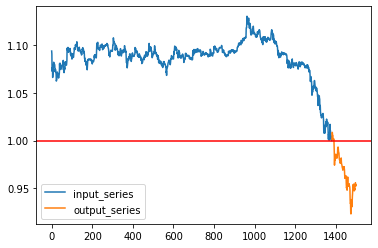

In [19]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

# 모델 훈련하기

## train 샘플 훈련하기

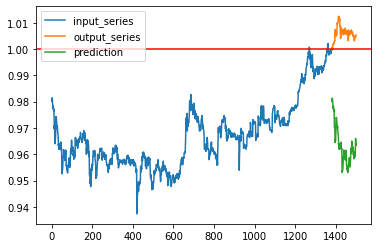

In [47]:
idx = 777
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

# ARIMA의 (p,d,q) 값은 최적화 되지않은 값 입니다.
model = ARIMA(x_series, order=(4, 0,0) )
fit  = model.fit()
preds = fit.predict(1,120, typ='levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label = 'prediction')
plt.legend()
plt.show()

## Validation set 훈련하기

### validation 데이터 생성하기

In [21]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

### 학습 및 추론하기

모델 선택 근거


In [22]:
pip install tbats

     |████████████████████████████████| 51kB 6.9MB/s 


In [23]:
# ARIMA의 (p,d,q) 값이 (5,1,1)에서 수렴하지 않을 경우
# (4,1,1)로 변경하여 다시 학습 및 추론
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,1]
            # 비계절성 ARIMA
            model = ARIMA(x_series, order=(3,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds - (preds[0]-x_series[-1])
        except:
            print("order 4 1 1")
            x_series = valid_x_array[idx,:,1]

            #seasonal = False로 비계절성 ARIMA를 했었는데 계속 투자를 안한다 ...
            model = ARIMA(x_series, order=(2,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

100%|██████████| 300/300 [02:43<00:00,  1.84it/s]


### valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [24]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 10% 이상 상승하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.10) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도|
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [25]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [26]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,36
1,1,0,24
2,2,0,44
3,3,0,76
4,4,0,95
...,...,...,...
295,295,0,35
296,296,0,1
297,297,0,19
298,298,0,25


In [27]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0    297
1      3
Name: buy_quantity, dtype: int64

### 투자 후 금액 계산하기

In [28]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [29]:

total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [30]:

# 투자 후 금액
print(total_momey)

10252.202648040653


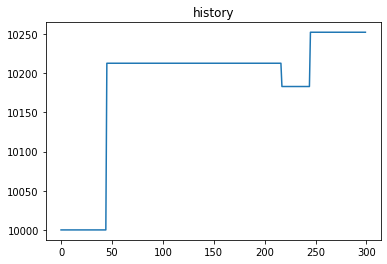

In [31]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# test 데이터 학습하고 추론하기

In [32]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        try:
            x_series = test_x_array[idx,:,1]

            model = ARIMA(x_series, order=(3,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
        except:
            x_series = test_x_array[idx,:,1]
            model = ARIMA(x_series, order=(2,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [03:44<00:00,  2.35it/s]


In [33]:
submission = array_to_submission(test_x_array, test_pred_array)

In [34]:
submission.to_csv("baseline_submission.csv", index = False)